In [1]:
from numpy import vectorize
import pandas as pd
from sklearn import preprocessing
import streamlit as st
from nltk.stem import WordNetLemmatizer
import tweepy, pandas, configparser, re, nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [6]:
vectorizer = CountVectorizer()
tfidf = TfidfVectorizer()


def count_vectorizer(x_train, x_test):
    x_train  = vectorizer.fit_transform(x_train)
    x_test = vectorizer.transform(x_test)
    return x_train, x_test

def tfid_vectorizer(X_train_tfidf, X_test_tfidf):
    X_train_tfidf = tfidf.fit_transform(X_train_tfidf)
    X_test_tfidf = tfidf.transform(X_test_tfidf)
    return X_train_tfidf, X_test_tfidf



def tweet_search(city, type, approach, split_size):

    config = configparser.ConfigParser()
    config.read('.\\pages\\config.ini')

    consumer_key = config['twitter']['api_key']
    consumer_secret = config['twitter']['api_key_secret']
    access_token = config['twitter']['access_token']
    access_secret = config['twitter']['access_token_secret']

    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    api = tweepy.API(auth)

    query1 = city + " " + 'traffic -filter:retweets'
    query2 = city + " " + 'roadblock -filter:retweets'
    query3 = city + " " + 'accident -filter:retweets'
    query4 = city + " " + 'road closed -filter:retweets'
    query5 = city + " " + 'blocked -filter:retweets'
    query6 = city + " " + 'traffic jam -filter:retweets'

    
    tweets_array = []
    tweets1 = tweepy.Cursor(api.search_tweets, q=query1, lang='en', tweet_mode='extended', result_type='recent').items(500)
    tweets2 = tweepy.Cursor(api.search_tweets, q=query2, lang='en', tweet_mode='extended', result_type='recent').items(500)
    tweets3 = tweepy.Cursor(api.search_tweets, q=query3, lang='en', tweet_mode='extended', result_type='recent').items(500)
    tweets4 = tweepy.Cursor(api.search_tweets, q=query4, lang='en', tweet_mode='extended', result_type='recent').items(500)
    tweets5 = tweepy.Cursor(api.search_tweets, q=query5, lang='en', tweet_mode='extended', result_type='recent').items(500)
    tweets6 = tweepy.Cursor(api.search_tweets, q=query6, lang='en', tweet_mode='extended', result_type='recent').items(500)
    for tweet in tweets1:
        tweets_array.append([tweet.user.screen_name, tweet.full_text,tweet.created_at])
    for tweet in tweets2:
        tweets_array.append([tweet.user.screen_name, tweet.full_text,tweet.created_at])
    for tweet in tweets3:
        tweets_array.append([tweet.user.screen_name, tweet.full_text,tweet.created_at])
    for tweet in tweets4:
        tweets_array.append([tweet.user.screen_name, tweet.full_text,tweet.created_at])
    for tweet in tweets5:
        tweets_array.append([tweet.user.screen_name, tweet.full_text,tweet.created_at])
    for tweet in tweets6:
        tweets_array.append([tweet.user.screen_name, tweet.full_text,tweet.created_at])

    df = pandas.DataFrame(tweets_array, columns=['username', 'tweet', 'timestamp'])
    df['date'] = pandas.to_datetime(df['timestamp']).dt.date
    df['time'] = pandas.to_datetime(df['timestamp']).dt.time
    df = df.drop('timestamp', axis=1)   

    #streamlit.dataframe(df, height=1000, width=1000)

    samp_df = pandas.read_csv(".\\pages\\trainingData.csv")
    samp_df['Classification'] = samp_df['class'].apply(pp.convert)
    samp_df['processed_text'] = samp_df['text'].apply(pp.lemmatization)
    samp_df['processed_text'].apply(pp.preprocess_tweets)

    x_train, x_test, y_train, y_test = train_test_split(samp_df.processed_text, samp_df.Classification, test_size=split_size, random_state=101)
    
    if type == 1:
        x_train, x_test = count_vectorizer(x_train, x_test)
    elif type == 2:
        x_train, x_test = tfid_vectorizer(x_train, x_test)
    else:
        pass

    rf = RandomForestClassifier()
    rf.fit(x_train, y_train)
    rf_train_score = rf.score(x_train,y_train)
    rf_test_score = rf.score(x_test,y_test)

    nb = MultinomialNB()
    nb.fit(x_train, y_train)
    nb_train_score = nb.score(x_train,y_train)
    nb_test_score = nb.score(x_test,y_test)

    logreg = LogisticRegression()
    logreg.fit(x_train, y_train)
    logreg_train_score = logreg.score(x_train,y_train)
    logreg_test_score = logreg.score(x_test,y_test)

    predictions1 = logreg.predict(x_test)
    logreg_acc_score = accuracy_score(y_test, predictions1)
    predictions2 = nb.predict(x_test)
    nb_acc_score = accuracy_score(y_test, predictions2)
    predictions3 = rf.predict(x_test)
    rf_acc_score =  accuracy_score(y_test, predictions3)

    d = {
    'Logistic Regression' : [logreg_test_score, logreg_train_score, logreg_acc_score],
    'Naive-Bayes' : [nb_test_score ,nb_train_score, nb_acc_score],
    'Random Forest' : [rf_test_score, rf_train_score, rf_acc_score]
    }
    labels = ["Test Score", "Train Score", "Accuracy Score"]
    scores_df = pd.DataFrame(d, index=labels)


    # PREDICTION:

    raw_tweets = df['tweet']
    raw_tweets = raw_tweets.apply(pp.preprocess_tweets)
    raw_tweets = raw_tweets.apply(pp.lemmatization)
    
    if type == 1:
        bow = vectorizer.transform(raw_tweets)
        if approach == 1:
            predictions = logreg.predict(bow)
        elif approach == 2:
            predictions = nb.predict(bow)
        else:
            predictions = rf.predict(bow)
    
    elif type == 2:
        bow = tfidf.transform(raw_tweets)
        if approach == 1:
            predictions = logreg.predict(bow)
        elif approach == 2:
            predictions = nb.predict(bow)
        else:
            predictions = rf.predict(bow)
    

    df['predicted_class'] = predictions
    new_df = df[df['predicted_class'] == 1]
    new_df = new_df.drop('predicted_class', axis=1)
    new_df = new_df.reset_index(drop=True)



    # ROC

    r_probs = [0 for _ in range(len(y_test))]
    rf_probs = rf.predict_proba(x_test)
    nb_probs = nb.predict_proba(x_test)
    logreg_probs = logreg.predict_proba(x_test)
    
    rf_probs = rf_probs[:, 1]
    nb_probs = nb_probs[:, 1]
    logreg_probs = logreg_probs[:, 1]

    r_auc = roc_auc_score(y_test, r_probs)
    rf_auc = roc_auc_score(y_test, rf_probs)
    nb_auc = roc_auc_score(y_test, nb_probs)
    logreg_auc = roc_auc_score(y_test, logreg_probs)

    r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
    rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
    nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
    logreg_fpr, logreg_tpr, _ = roc_curve(y_test, logreg_probs)

    return df, new_df

In [7]:
df, new_df = tweet_search("seattle",1,1,0.3)

In [15]:
df.shape[0]

955

In [10]:
new_df

,username,tweet,date,time
0,TotalTrafficSEA,Delays up to two hours in #Edmonds/Kingston on...,2022-07-16,16:30:43
1,TotalTrafficSEA,Blocked due to accident in #HbrIsland/WestSeat...,2022-07-16,02:15:44
2,TotalTrafficSEA,Blocked due to accident in #HbrIsland/WestSeat...,2022-07-16,02:15:43
3,TotalTrafficSEA,Closed due to accident in #InternationalDistri...,2022-07-15,19:30:43
4,TotalTrafficSEA,Closed due to accident in #InternationalDistri...,2022-07-15,19:30:43
...,...,...,...,...
215,TotalTrafficSEA,Accident. Four lanes blocked. in #FederalWay ...,2022-07-07,00:30:43
216,TotalTrafficSEA,Accident. Two right lanes blocked. in #Federal...,2022-07-07,00:15:43
217,TotalTrafficSEA,Accident. Right lane blocked in #Pacific on SR...,2022-07-06,21:35:43
218,seattletimes,"UPDATE: At 7:13 a.m., four vehicles got into a...",2022-07-08,16:45:36


In [16]:
new_df.shape[0]

220

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<BarContainer object of 2 artists>

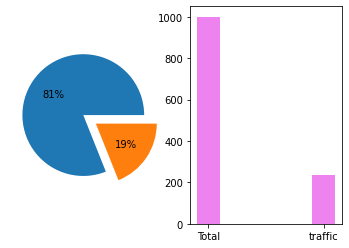

In [23]:
df_size = 1000
new_df_size = 234

arr = [df_size, new_df_size]

plt.subplot(1,2,1)

plt.pie(arr, explode=[0,0.25], autopct='%.0f%%')

plt.subplot(1,2,2)
plt.bar(['Total','traffic'],arr, color='violet',width=0.2)